# Diabetes prediction: decision threshold tuning

## Notebook set-up

In [ ]:
# Python standard library imports
import os
import pickle
import time

# PyPI imports - data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyPI imports - machine learning libraries
from sklearn.model_selection import cross_val_score, TunedThresholdClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Internal imports - project-specific modules
import configuration as config
import functions as funcs

# Wait for the gradient boosting notebook to finish execution before proceeding
# This ensures all required model files are available
while True:
    if os.path.exists(config.GRADIENT_BOOSTING_MODEL):
        break
    else:
        time.sleep(5)  # Check every 5 seconds

## 1. Data preparation

### 1.1. Load data from disk

In [2]:
# Load the preprocessed dataset that was saved from the decision tree notebook
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

# Extract training and testing dataframes from the loaded dictionary
training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
725,4,112,78,40,0,39.4,0.236,38,0
66,0,109,88,30,0,32.5,0.855,38,1
175,8,179,72,42,130,32.7,0.719,36,1
1,1,85,66,29,0,26.6,0.351,31,0
209,7,184,84,33,0,35.5,0.355,41,1


## 2. Model comparisons

In this section, we compare the performance of all the machine learning algorithms we've trained and optimized in previous notebooks. This comprehensive comparison helps us identify the best-performing model before applying threshold tuning.

### 2.1. Cross-validation accuracy

**Why compare models systematically?**

Before diving into threshold optimization, we need to establish which algorithm performs best with standard evaluation metrics. Each algorithm has different strengths and weaknesses:

**Logistic Regression:**
- **Strengths**: Simple, interpretable, fast training, good baseline
- **Assumptions**: Linear relationship between features and log-odds
- **Best for**: When interpretability is crucial, linearly separable data

**Decision Tree:**
- **Strengths**: Highly interpretable, handles non-linear relationships, no feature scaling needed
- **Weaknesses**: Prone to overfitting, unstable (small data changes = different trees)
- **Best for**: When you need to explain decisions, feature interactions matter

**Random Forest:**
- **Strengths**: Reduces overfitting, handles missing values, provides feature importance
- **How it works**: Combines many decision trees with voting
- **Best for**: Robust performance across various datasets, good default choice

**Gradient Boosting:**
- **Strengths**: Often highest accuracy, learns from mistakes sequentially
- **How it works**: Builds models iteratively, each correcting previous errors
- **Best for**: When accuracy is paramount, complex patterns in data

**Cross-validation methodology:**
- Uses k-fold cross-validation for robust performance estimates
- Prevents overly optimistic results from single train-test splits
- Provides confidence intervals (variance) in model performance

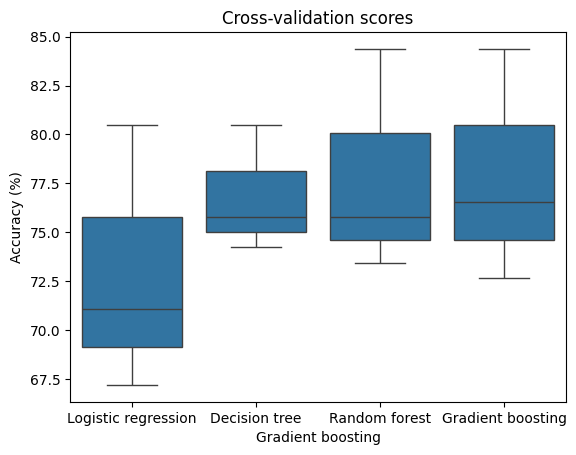

In [4]:
# Initialize dictionary to store all trained models for comparison
models = {}

# Load the logistic regression model from previous notebook
with open(config.LOGISTIC_REGRESSION_MODEL, 'rb') as input_file:
    models['Logistic regression'] = pickle.load(input_file)

# Load the best decision tree model from previous notebook
with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree'] = pickle.load(input_file)

# Load the best random forest model from previous notebook
with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest'] = pickle.load(input_file)

# Load the best gradient boosting model from previous notebook
with open(config.GRADIENT_BOOSTING_MODEL, 'rb') as input_file:
    models['Gradient boosting'] = pickle.load(input_file)

# Initialize dictionary to store cross-validation scores for comparison
cross_val_scores = {
    'Model': [],
    'Score': []
}

# Perform cross-validation for each model and collect scores
for model_name, model in models.items():
    scores = cross_val_score(
        model,
        training_df.drop('Outcome', axis=1),
        training_df['Outcome'],
        cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
        n_jobs=-1                   # Use all available CPU cores
    )

    # Store results for visualization
    cross_val_scores['Model'].extend([model_name]*len(scores))
    cross_val_scores['Score'].extend(np.array(scores)*100)

# Create boxplot to compare cross-validation performance across all models
plt.title(f'Cross-validation scores')
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.xlabel(model_name)
plt.ylabel('Accuracy (%)')
plt.show()

### 2.2. Test set performance

While cross-validation scores give us a robust estimate of model performance, the ultimate test is how well each model performs on completely unseen data - our held-out test set.

**Why test set evaluation matters:**

**Unbiased performance estimate:**
- Test data was never seen during training or hyperparameter optimization
- Provides realistic estimate of real-world performance
- Reveals if models generalize well beyond training data

**Confusion matrix insights:**
- **True Positives (TP)**: Correctly identified diabetes cases - critical for patient health
- **True Negatives (TN)**: Correctly identified healthy patients - avoids unnecessary anxiety
- **False Positives (FP)**: Healthy patients misclassified as diabetic - leads to unnecessary tests
- **False Negatives (FN)**: Diabetic patients missed - potentially dangerous for patient health

**Medical context considerations:**
- In healthcare, False Negatives are typically more costly than False Positives
- Missing a diabetes diagnosis can lead to serious complications
- A false alarm leads to additional testing but catches the condition if present
- This asymmetric cost structure will influence our threshold optimization later

**What to look for in confusion matrices:**
- **Sensitivity (Recall)**: TP/(TP+FN) - ability to catch positive cases
- **Specificity**: TN/(TN+FP) - ability to correctly identify negative cases  
- **Precision**: TP/(TP+FP) - when model says positive, how often is it right?
- **Overall patterns**: Which models show better balance between error types?

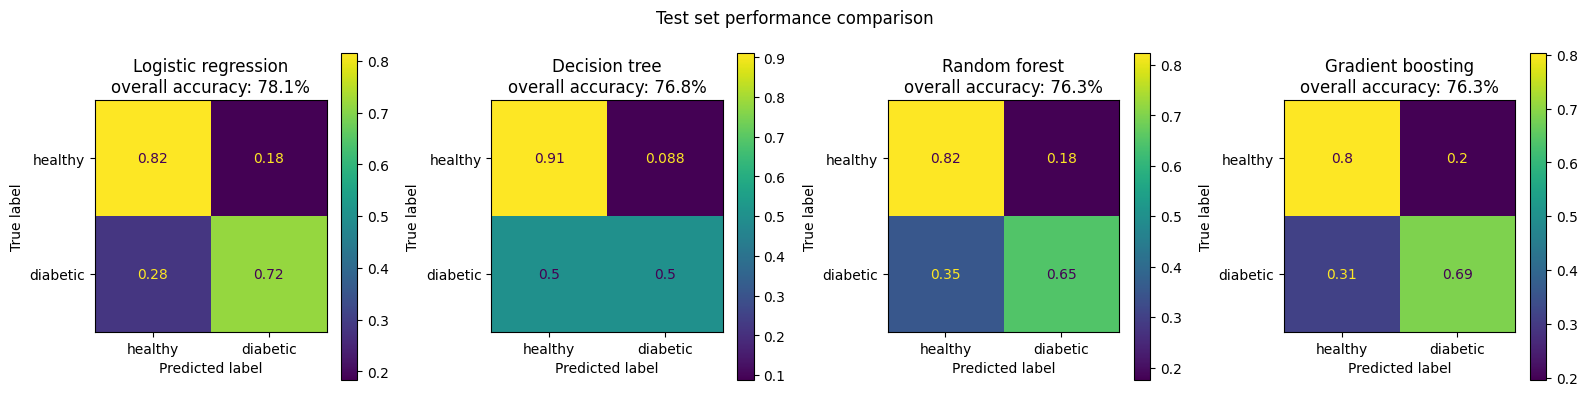

In [5]:
funcs.plot_confusion_matrices(models=models, testing_df=testing_df)

## 3. Decision threshold analysis

### 3.1. Predicted class probabilities

Understanding how well-calibrated our models are by examining their predicted probabilities:

Before we can optimize decision thresholds, we need to understand how our models generate probability predictions. Well-calibrated models should produce probabilities that reflect the true likelihood of each class. For example, when a model predicts a 70% probability of diabetes, approximately 70% of such cases should actually have diabetes.

By examining the distribution of predicted probabilities for each true class, we can assess:
- **Model confidence**: How confident are the models in their predictions?
- **Class separation**: How well do the models distinguish between the two classes?
- **Calibration quality**: Are the predicted probabilities realistic estimates of true probabilities?

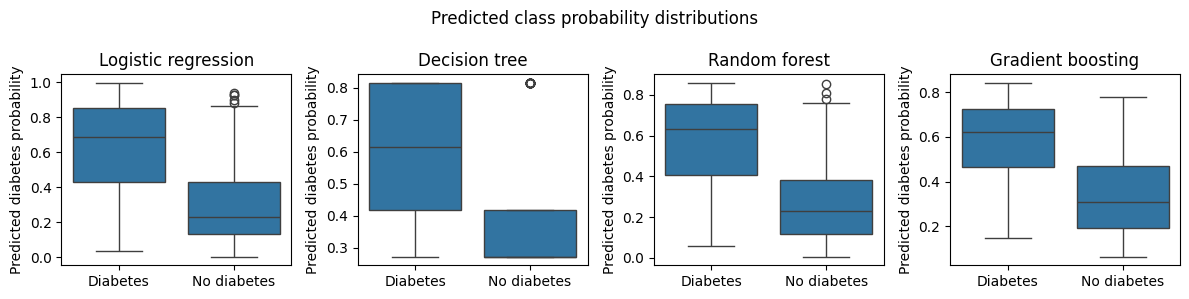

In [6]:
# Create subplot grid for threshold comparison (2 rows: probabilities + confusion matrices)
fig, axs = plt.subplots(1,4, figsize=(12,3))
axs = axs.flatten()

fig.suptitle(f'Predicted class probability distributions')

for i, (model_name, model) in enumerate(models.items()):

    # Extract class probabilities from logistic regression model for threshold analysis
    class_probabilities = model.predict_proba(testing_df.drop('Outcome', axis=1))

    # Create dataframe with probabilities and actual labels for visualization
    testing_probabilities_df = pd.DataFrame({
        'Diabetes probability': class_probabilities[:,1],  # Probability of class 1 (diabetes)
        'Label': testing_df['Outcome']
    })

    # Create human-readable outcome labels for plotting
    testing_probabilities_df['Outcome'] = testing_probabilities_df['Label'].map({0: 'No diabetes', 1: 'Diabetes'})

    sns.boxplot(testing_probabilities_df, x='Outcome', y='Diabetes probability', ax=axs[i])
    axs[i].set_title(model_name)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Predicted diabetes probability')

fig.tight_layout()

### 3.2. Call threshold comparison  

By default, classification models use a decision threshold of 0.5 - if the predicted probability is above 0.5, the model predicts the positive class. However, this threshold may not be optimal for all problems, especially with imbalanced datasets.

**Why threshold tuning matters:**
- **Medical diagnosis**: False negatives (missing diabetes cases) might be more costly than false positives (unnecessary follow-up tests)
- **Class imbalance**: When one class is rare, the default 0.5 threshold often leads to poor recall for the minority class
- **Business objectives**: Different applications may prioritize precision vs. recall differently

**Key considerations:**
- **Lower thresholds (e.g., 0.2)**: More sensitive, catch more positive cases but increase false alarms
- **Higher thresholds (e.g., 0.7)**: More specific, fewer false alarms but might miss positive cases
- **Cost-benefit analysis**: The optimal threshold depends on the relative costs of false positives vs. false negatives

Let's examine how different thresholds affect the performance of our best model:

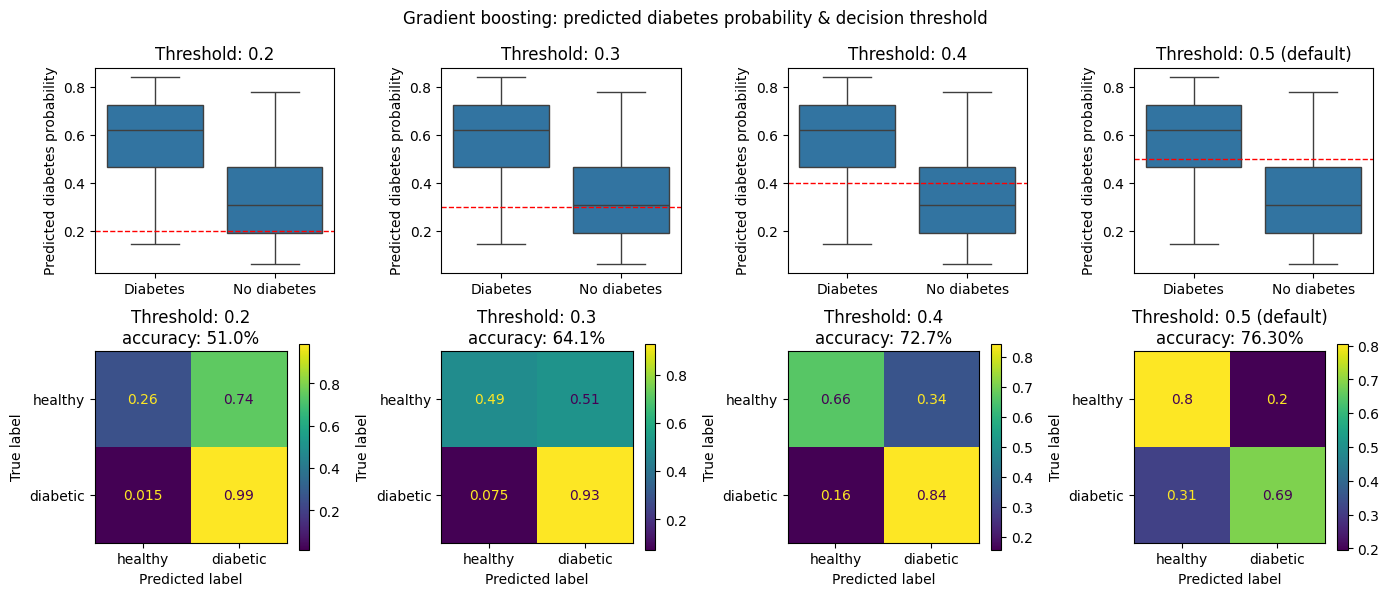

In [7]:
# Define different decision thresholds to compare (default is 0.5)
call_thresholds = [0.20, 0.30, 0.40, 0.5]
class_probabilities = models['Gradient boosting'].predict_proba(testing_df.drop('Outcome', axis=1))

# Create subplot grid for threshold comparison (2 rows: probabilities + confusion matrices)
fig, axs = plt.subplots(2,4, figsize=(14,6))

fig.suptitle(f'Gradient boosting: predicted diabetes probability & decision threshold')

# For each threshold, create probability distribution plot and confusion matrix
for i, threshold in enumerate(call_thresholds):

    # Top row: Plot probability distributions with threshold line
    sns.boxplot(testing_probabilities_df, x='Outcome', y='Diabetes probability', ax=axs[0,i])
    axs[0,i].axhline(threshold, color='red', linestyle='dashed', linewidth=1)

    # Label default threshold differently
    if threshold == 0.5:
        axs[0,i].set_title(f'Threshold: {threshold} (default)')
    else:
        axs[0,i].set_title(f'Threshold: {threshold}')

    axs[0,i].set_xlabel('')
    axs[0,i].set_ylabel('Predicted diabetes probability')

    # Bottom row: Generate predictions using threshold and plot confusion matrix
    calls = [1 if p > threshold else 0 for p in class_probabilities[:,1]]
    accuracy = accuracy_score(calls, testing_df['Outcome'])*100

    # Create normalized confusion matrix
    cm = confusion_matrix(testing_df['Outcome'], calls, normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['healthy','diabetic'])

    # Label with threshold and accuracy
    if threshold == 0.5:
        axs[1,i].set_title(f'Threshold: {threshold} (default)\naccuracy: {accuracy:.2f}%')
    else:
        axs[1,i].set_title(f'Threshold: {threshold}\naccuracy: {accuracy:.1f}%')

    _ = cm_disp.plot(ax=axs[1,i])

# Adjust layout to prevent overlapping
fig.tight_layout()

## 4. Decision threshold optimization

### 4.1. Threshold scan

To find the optimal threshold, we need to understand how false positive and false negative rates change across different threshold values. This helps us make informed decisions about the trade-offs between different types of errors.

**Understanding the error rate curves:**

**False Positive Rate (FPR)**:
- Formula: FP / (FP + TN)
- Represents the fraction of healthy patients incorrectly classified as diabetic
- Decreases as threshold increases (fewer false alarms)
- In medical context: Unnecessary stress and follow-up tests for healthy patients

**False Negative Rate (FNR)**:
- Formula: FN / (FN + TP)  
- Represents the fraction of diabetic patients incorrectly classified as healthy
- Increases as threshold increases (more missed cases)
- In medical context: Missed diagnoses that could lead to serious health complications

**The optimization challenge:**
- These error rates move in opposite directions as we adjust the threshold
- The intersection point represents equal error rates
- The optimal threshold depends on the relative costs and consequences of each error type
- Medical applications typically prefer lower thresholds to minimize missed diagnoses

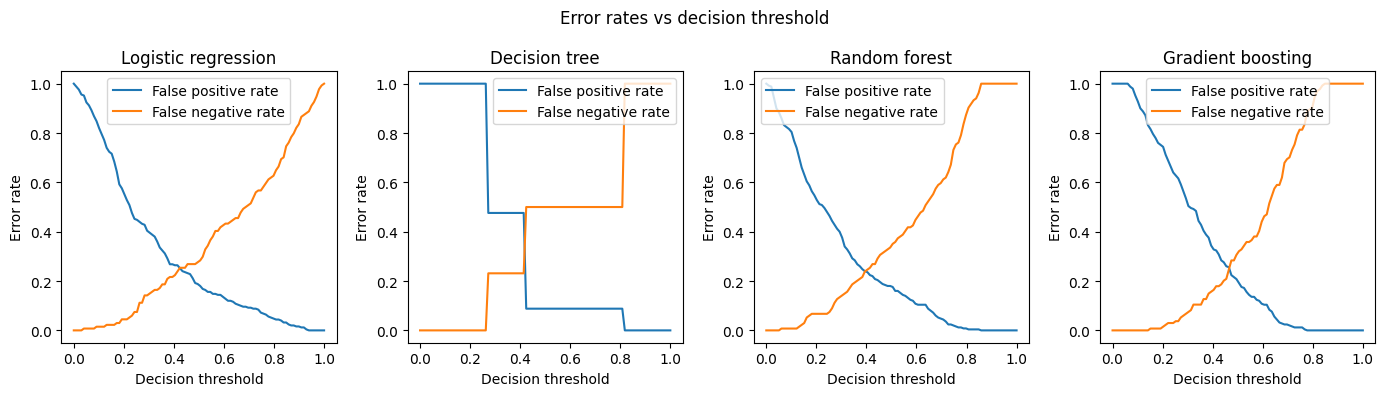

In [8]:
# Create subplot grid to analyze error rates vs threshold for each model
fig, axs = plt.subplots(1,4, figsize=(14,4))
axs = axs.flatten()

fig.suptitle(f'Error rates vs decision threshold')

# Analyze each model's performance across different thresholds
for i, (model_name, model) in enumerate(models.items()):

    # Initialize dictionary to store error rates at different thresholds
    error_rates = {
        'Threshold': [],
        'False positive rate': [],
        'False negative rate': []
    }

    # Test thresholds from 0 to 1 with 100 points
    call_thresholds = np.linspace(0, 1, 100)

    # Get class probabilities for the current model
    class_probabilities = model.predict_proba(testing_df.drop('Outcome', axis=1))

    # Calculate error rates for each threshold
    for j, threshold in enumerate(call_thresholds):
        # Make predictions using current threshold
        calls = [1 if p > threshold else 0 for p in class_probabilities[:,1]]
        cm = confusion_matrix(testing_df['Outcome'], calls)

        # Extract confusion matrix components: True Negative, False Positive, False Negative, True Positive
        tn, fp, fn, tp = cm.ravel()

        # Calculate error rates
        error_rates['False positive rate'].append(fp / (fp + tn))  # FPR = FP / (FP + TN)
        error_rates['False negative rate'].append(fn / (fn + tp))  # FNR = FN / (FN + TP)
        error_rates['Threshold'].append(threshold)

    # Plot error rates for current model
    axs[i].set_title(f'{model_name}')
    axs[i].plot(error_rates['Threshold'], error_rates['False positive rate'], label='False positive rate')
    axs[i].plot(error_rates['Threshold'], error_rates['False negative rate'], label='False negative rate')
    axs[i].set_xlabel('Decision threshold')
    axs[i].set_ylabel('Error rate')
    axs[i].legend(loc='best')

# Adjust layout to prevent overlapping
fig.tight_layout()

### 4.2. Automated threshold tuning

Instead of manually selecting thresholds, we can use scikit-learn's `TunedThresholdClassifierCV` to automatically find the optimal threshold using cross-validation. This approach optimizes for balanced accuracy, which is particularly useful for imbalanced datasets.

**How TunedThresholdClassifierCV works:**

1. **Cross-validation setup**: Uses k-fold CV to ensure robust threshold selection
2. **Threshold search**: Tests multiple threshold values across the range [0, 1]
3. **Scoring optimization**: Optimizes for balanced accuracy by default
4. **Best threshold selection**: Chooses the threshold that maximizes the chosen metric

**Why balanced accuracy?**
- **Formula**: (Sensitivity + Specificity) / 2
- **Sensitivity (Recall)**: TP / (TP + FN) - ability to correctly identify positive cases
- **Specificity**: TN / (TN + FP) - ability to correctly identify negative cases
- **Balance**: Gives equal weight to performance on both classes, preventing bias toward the majority class
- **Imbalanced data**: More appropriate than standard accuracy when classes are unequal

**Advantages of automated tuning:**
- Removes manual guesswork and potential bias
- Uses cross-validation for robust threshold selection
- Consistent methodology across different models
- Can easily switch optimization metrics based on problem requirements

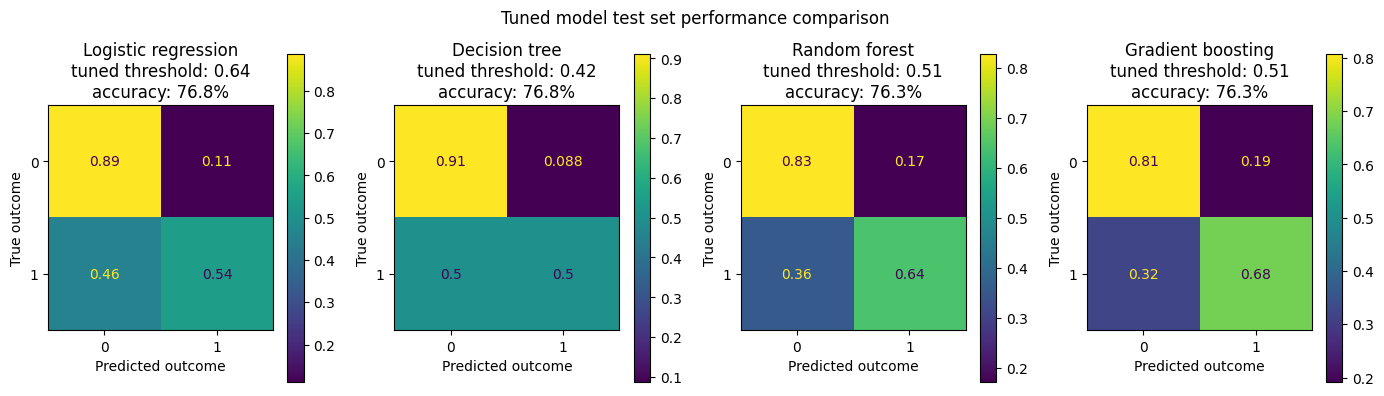

In [ ]:
# Create subplot grid to compare tuned threshold performance for each model
fig, axs = plt.subplots(1,4, figsize=(14,4))
axs = axs.flatten()

fig.suptitle(f'Tuned model test set performance comparison')

# Apply threshold tuning to each model
for i, (model_name, model) in enumerate(models.items()):

    # Create threshold-tuned version of the model using cross-validation
    tuned_model = TunedThresholdClassifierCV(
        model,
        scoring='balanced_accuracy',     # Optimize for balanced accuracy (handles class imbalance)
        cv=config.CROSS_VAL_FOLDS,       # Number of cross-validation folds
        n_jobs=-1,                       # Use all available CPU cores
        random_state=config.RANDOM_SEED  # Ensure reproducible results
    )

    # Fit the threshold tuner on training data to find optimal threshold
    tuned_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
    
    # Replace original model with tuned version in models dictionary
    models[model_name] = tuned_model

    # Make predictions on test set using optimized threshold
    testing_predictions = tuned_model.predict(testing_df.drop('Outcome', axis=1))
    accuracy = accuracy_score(testing_predictions, testing_df['Outcome'])*100

    # Create normalized confusion matrix for tuned model
    cm = confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    _ = cm_disp.plot(ax=axs[i])

    # Display model name, optimal threshold, and accuracy
    axs[i].set_title(f'{model_name}\ntuned threshold: {tuned_model.best_threshold_:.2f}\naccuracy: {accuracy:.1f}%')
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

# Adjust layout to prevent overlapping
fig.tight_layout()

## 5. Save final model

### 5.1. Model persistence

After comparing all algorithms and optimizing decision thresholds, we save the best performing model for future use. The threshold-tuned gradient boosting model represents our final solution for diabetes prediction.

**Why this model is our final choice:**

**Algorithm advantages:**
- **Gradient boosting**: Sequential ensemble method that learns from previous mistakes
- **Robustness**: Less prone to overfitting than individual decision trees
- **Feature interactions**: Capable of capturing complex relationships in the data
- **Performance**: Typically achieves high accuracy on tabular data

**Threshold optimization benefits:**
- **Balanced accuracy**: Optimized for equal performance on both classes
- **Medical relevance**: Better suited for healthcare applications where missing positive cases is costly
- **Cross-validation**: Threshold selected using robust validation methodology
- **Generalization**: More likely to perform well on new, unseen data

**Production readiness:**
- **Preprocessing included**: KNN imputation for missing values is built into the pipeline
- **Calibrated thresholds**: Decision boundary optimized for the specific problem
- **Serialized model**: Saved as pickle file for easy deployment and reuse
- **Reproducible**: All random states set for consistent results

In [10]:
with open(config.FINAL_MODEL, 'wb') as output_file:
    pickle.dump(models['Gradient boosting'], output_file)